In [42]:
library("adabag")
library("randomForest")
library("e1071")


# 1)

In [2]:
load("TP4.Rdata")



In [33]:
# formula es lo que pones en el metodo para señalar la variable clase
# por ej. class ~ .
calculador.error <- function(train, test, formula) {
    error <- matrix(0, ncol = 2, nrow = 0)
    colnames(error) <- c("altura_arbol", "error")

    for (i in 1:20) {
        adaboost <- boosting(formula, data = train, mfinal = 200, coef = "Freund", control = rpart.control(maxdepth = i))
        pred <- predict(adaboost, newdata = test, type = "class")
        error <- rbind(error, c(i, pred$error))
    }

    return(error)
}



In [34]:
esp_error <- calculador.error(esp_train, esp_test, class ~ .)
diag_error <- calculador.error(diag_train, diag_test, class ~ .)



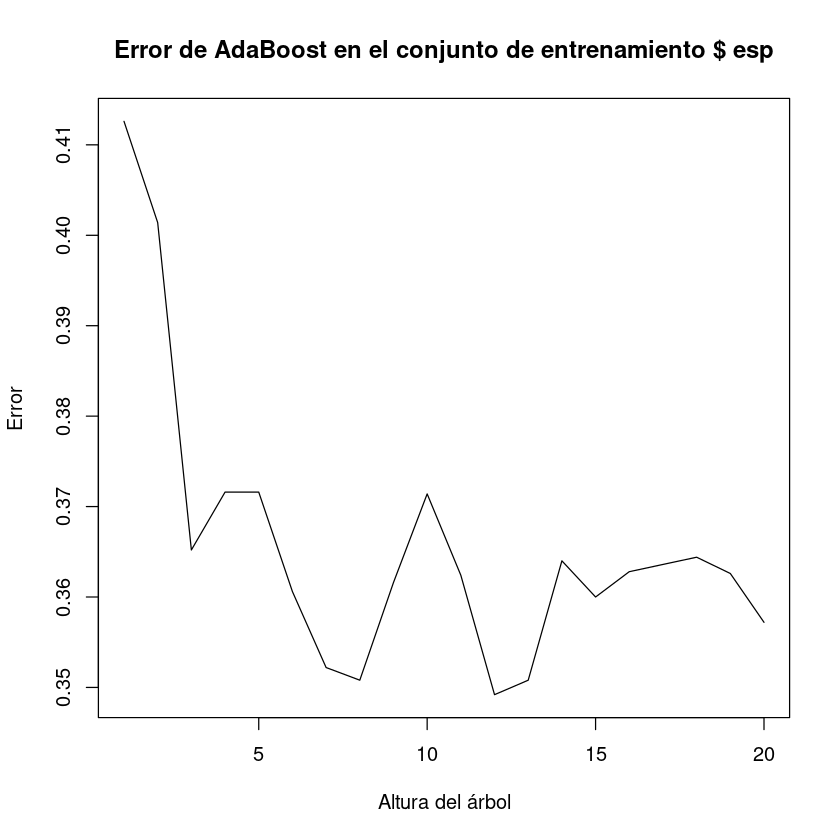

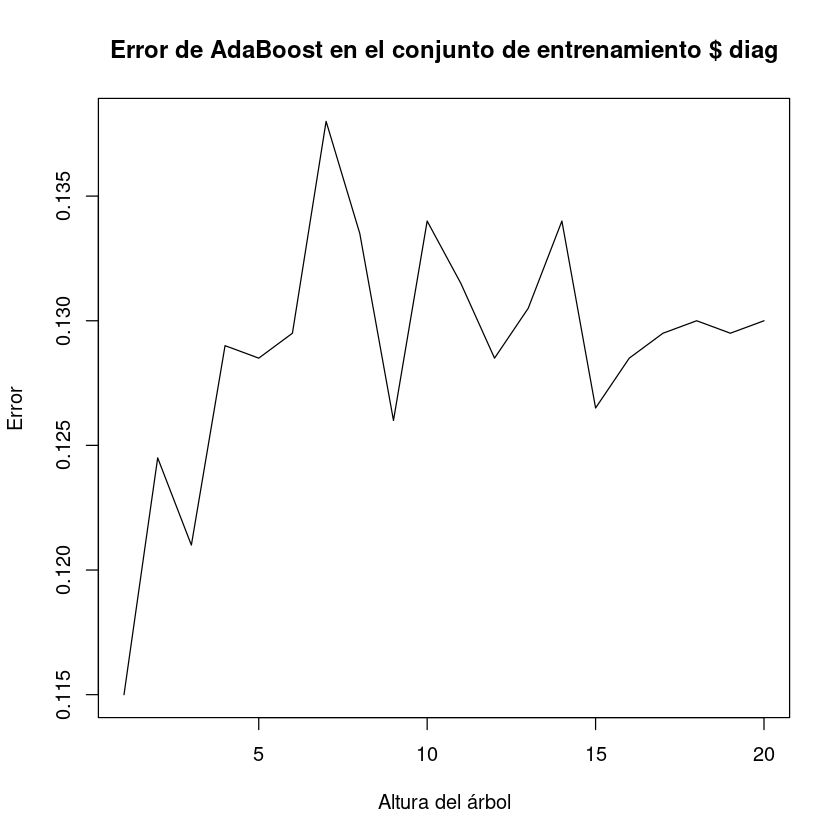

In [35]:
plot(esp_error[, 1], esp_error[, 2], type = "l", xlab = "Altura del árbol", ylab = "Error", main = "Error de AdaBoost en el conjunto de entrenamiento $ esp")
plot(diag_error[, 1], diag_error[, 2], type = "l", xlab = "Altura del árbol", ylab = "Error", main = "Error de AdaBoost en el conjunto de entrenamiento $ diag")


## Comentarios

lorem ipsum dolor sit amet 

# 2)

In [23]:
n.variables <- function(n) {
    r <- c(n)
    p <- floor(n / 2)
    while (p > 0) {
        r <- c(r, p)
        p <- floor(p / 2)
    }
    return(r)
}


In [20]:
# rforest tiene que ser una función que recibe un parametro para aplicar mtry a un dataset
tester.nvars <- function(dataset, formula) {
    n <- ncol(dataset) - 1
    error <- matrix(0, ncol = 2, nrow = 0)
    colnames(error) <- c("n_variables", "error")

    for (i in n.variables(n)) {
        i_error <- c()
        for (j in 1:5) {
            rf <- randomForest(formula, data = dataset, mtry = i, ntree = 1000)
            i_error <- c(i_error, mean((rf$confusion)[, 3]))
        }
        error <- rbind(error, c(i, mean(i_error)))
    }

    return(error)
}



In [22]:
RRL_error <- tester.nvars(RRL, Tipo ~ .)



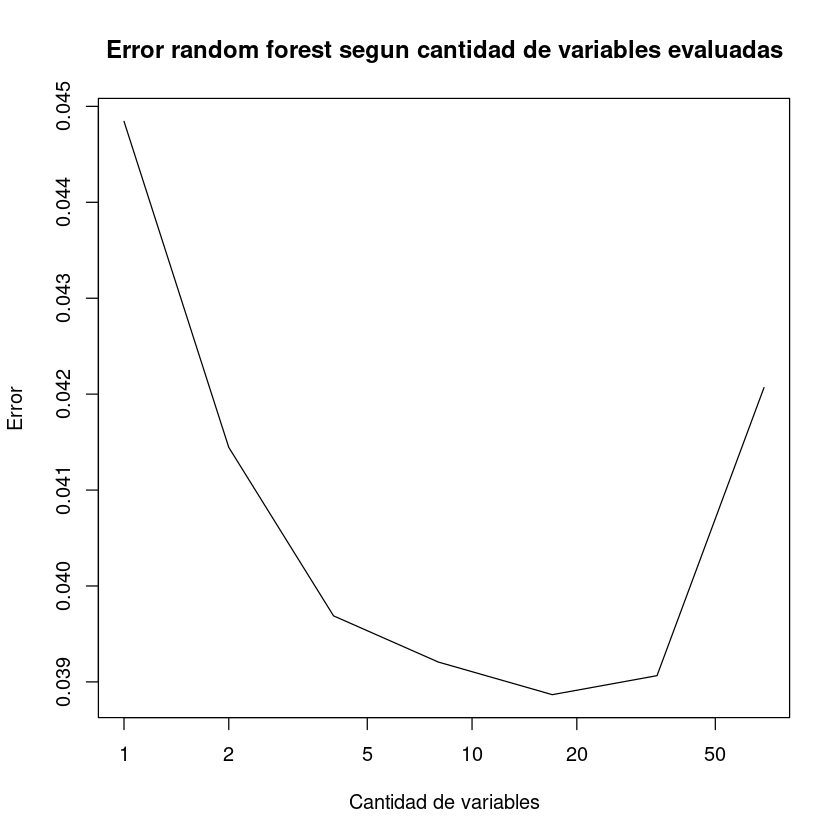

In [7]:
plot(RRL_error[, 1], RRL_error[, 2], type = "l", xlab = "Cantidad de variables", ylab = "Error", main = "Error random forest segun cantidad de variables evaluadas", log = "x")



## Conclusion

lorem ipsum dolor sit amet

# 3)

In [30]:
load("lampone.Rdata")
lampone.data <- lampone[, -c(1, 144)] # Quito la columna del año y la que me dijo Gurvich en TP3
dim(lampone.data) # 49 x 142


[1]  49 142

### Error con randomForest

A partir del punto 2 creo que el mtry es óptimo en 1/4 de la cantidad de variables (En este caso como tiene 141 variables, el óptimo sería 35). Igualmente voy a correr la misma función con lampone porque la computadora es mía y ejecuto lo que quiero.

In [32]:
lampone_mvars <- tester.nvars(lampone.data, N_tipo ~ .)
lampone_mvars


n_variables,error
141,0.15589226
70,0.11717172
35,0.08670034
17,0.09124579
8,0.09949495
4,0.10858586
2,0.12138047
1,0.15151515


Efectivamente el óptimo fue 35. Me quedo con su error de 8,67% o 0.08670034.

### Error con adaboost

Para elegir el alto del árbol uso la función del primer punto.

In [37]:
set.seed(123)
altura.train <- sample(1:nrow(lampone.data), 0.8 * nrow(lampone.data))
altura.test <- (-altura.train)
lampone.data2 <- lampone.data[sample(nrow(lampone.data)), ]
# Lo mezclo un poco para que no queden datos parecidos juntos


In [38]:
atrain <- lampone.data2[altura.train, ]
atest <- lampone.data2[altura.test, ]
calculador.error(atrain, atest, N_tipo ~ .)



altura_arbol,error
1,0.1
2,0.0
3,0.1
4,0.0
5,0.1
6,0.0
7,0.1
8,0.0
9,0.1
10,0.1


Parece que no importa mucho la altura del árbol mientras sea par, me voy a quedar con 2 para que no me tarde tanto (⌐■_■). 

Como lampone tiene muy pocos datos, creo que la mejor opción sería usar k-fold cross validation para generar train y test.

In [76]:
# Me copié el codigo del TP1 y lo adapté

# method tiene que esperar train y test, y devolver el error
kfold.apply <- function(dataset, method) {
    kfold <- 5
    folds <- cut(seq(1, nrow(dataset)), breaks = kfold, labels = FALSE)

    # Creo un vector de errores
    errores <- c()

    for (i in 1:kfold) {
        # Creo el conjunto de test
        tempTest <- dataset[folds == i, ]
        # Creo el conjunto de train
        tempTrain <- dataset[folds != i, ]

        error <- method(tempTrain, tempTest)
        errores <- c(errores, error)
    }

    cat("Los errores fueron:", errores, "\n")
    cat("El promedio de error fue: ", mean(errores) * 100, "%\n", sep = "")
}


In [91]:
altura <- 6
lampone.boost.err <- function(train, test) {
    adaboost <- boosting(N_tipo ~ ., data = tempTrain, mfinal = 200, coef = "Freund", control = rpart.control(maxdepth = altura))
    pred <- predict(adaboost, newdata = tempTest, type = "class")
    return(pred$error)
}

kfold.apply(lampone.data2, lampone.boost.err)


Los errores fueron: 0.1 0 0.1 0.1 0.1 
El promedio de error fue: 8%


Mentí, probe alturas que hayan dado 0 antes hasta que me dio error bajito :D. Ganó el 6

La última celda de arriba a veces da error de no se que, correr hasta que no de error. Intuyo que tiene que ver con los folds que se forman.

### Error con svm (RBF y Polinomial)

No se que usar para elegir los parametros óptimos de svm.

Acá también voy a tener que usar k-fold cross validation.

In [100]:
# predict lampone class with svm kernel rbf
svm.lampone.rbf <- function(train, test) {
    suppressWarnings(res <- svm(N_tipo ~ ., data = train, kernel = "radial", gamma = 0.01, cost = 2))
    pred <- predict(res, newdata = test)
    return(mean(pred != test$N_tipo))
}

# predict lampone class with svm kernel polinomial
svm.lampone.poly <- function(train, test) {
    suppressWarnings(res <- svm(N_tipo ~ ., data = train, kernel = "polynomial", degree = 2, gamma = 0.01, cost = 2))
    pred <- predict(res, newdata = test)
    return(mean(pred != test$N_tipo))
}
cat("SVM polinomial\n")
error.lampone.poly <- kfold.apply(lampone.data2, svm.lampone.poly)
cat("SVM RBF\n")
error.lampone.rbf <- kfold.apply(lampone.data2, svm.lampone.rbf)

SVM polinomial
Los errores fueron: 0.1 0.3 0.1111111 0.1 0.1 
El promedio de error fue: 14.22222%
SVM RBF
Los errores fueron: 0.8 0.5 0.1111111 0.7 0.4 
El promedio de error fue: 50.22222%


: 